# 추가 고급 방법

## DNN(Res10/SSD) 기반 얼굴 검출

### 튜닝 팁

- **CONF_TH**(0.5~0.7): 낮추면 더 잘 잡지만 오탐 ↑
- INPUT_SIZE: 모델 고정(300×300) 사용 권장
- HOLD_FRAMES: 5~15 사이로 조절하면 “깜빡임” 감소
- CPU가 느리면: 프레임 크기를 960×540로 줄여 입력(전처리 cv2.resize)


### 모델파일 다운로드
- https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
- https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel

In [4]:
import cv2
import numpy as np
from collections import deque
import os

# -----------------------------
# 모델 경로
# -----------------------------
PROTOTXT  = "deploy.prototxt"
CAFFEMODEL= "res10_300x300_ssd_iter_140000_fp16.caffemodel"  # 또는 .caffemodel

if not (os.path.exists(PROTOTXT) and os.path.exists(CAFFEMODEL)):
    raise FileNotFoundError("모델 파일을 ./models 폴더에 준비하세요.")

# -----------------------------
# 네트워크 로드 (DNN)
# -----------------------------
net = cv2.dnn.readNetFromCaffe(PROTOTXT, CAFFEMODEL)

# (옵션) CUDA 가속: OpenCV가 CUDA로 빌드되어 있으면 활성화
try:
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
except Exception:
    # CPU 사용
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# -----------------------------
# 파라미터
# -----------------------------
CONF_TH   = 0.6     # 신뢰도 임계값(낮추면 더 민감, 오탐↑)
INPUT_SIZE= (300, 300)
MEAN_VALS = (104.0, 177.0, 123.0)  # BGR 평균 (모델 규약)

HOLD_FRAMES = 10     # 검출 끊김 완화용(최근 박스 유지)
last_boxes = deque(maxlen=HOLD_FRAMES)

# -----------------------------
# 유틸: DNN으로 얼굴 상자 얻기
# -----------------------------
def detect_faces_dnn(frame):
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, scalefactor=1.0, size=INPUT_SIZE,
                                 mean=MEAN_VALS, swapRB=False, crop=False)
    net.setInput(blob)
    detections = net.forward()

    boxes = []
    for i in range(detections.shape[2]):
        confidence = float(detections[0, 0, i, 2])
        if confidence >= CONF_TH:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            # 화면 경계 클리핑
            x1 = max(0, x1); y1 = max(0, y1)
            x2 = min(w, x2); y2 = min(h, y2)
            if x2 > x1 and y2 > y1:
                boxes.append((x1, y1, x2 - x1, y2 - y1, confidence))
    return boxes

# -----------------------------
# 웹캠 시작
# -----------------------------
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("웹캠을 열 수 없습니다.")

print("[키] q: 종료")
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 얼굴 검출
    boxes = detect_faces_dnn(frame)

    # 끊김 방지: 검출 없으면 직전 박스들 잠시 유지
    if boxes:
        last_boxes.clear()
        last_boxes.extend(boxes)
    else:
        boxes = list(last_boxes)

    # 표시 & 모자이크
    for (x, y, w, h, conf) in boxes:
        # 모자이크
        roi = frame[y:y+h, x:x+w]
        if roi.size == 0:
            continue
        # 너무 작은 얼굴 대비(스케일 10~20 사이 권장)
        scale = max(10, min(20, min(w, h)//8))
        small = cv2.resize(roi, (max(1, w//scale), max(1, h//scale)), interpolation=cv2.INTER_LINEAR)
        mosaic = cv2.resize(small, (w, h), interpolation=cv2.INTER_NEAREST)
        frame[y:y+h, x:x+w] = mosaic

        # 박스/신뢰도 그리기 (원하면 주석 처리 가능)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 200, 0), 2)
        cv2.putText(frame, f"{conf:.2f}", (x, y-6), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (0, 200, 0), 2, cv2.LINE_AA)

    cv2.imshow("DNN Face Mosaic (q=quit)", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


[키] q: 종료


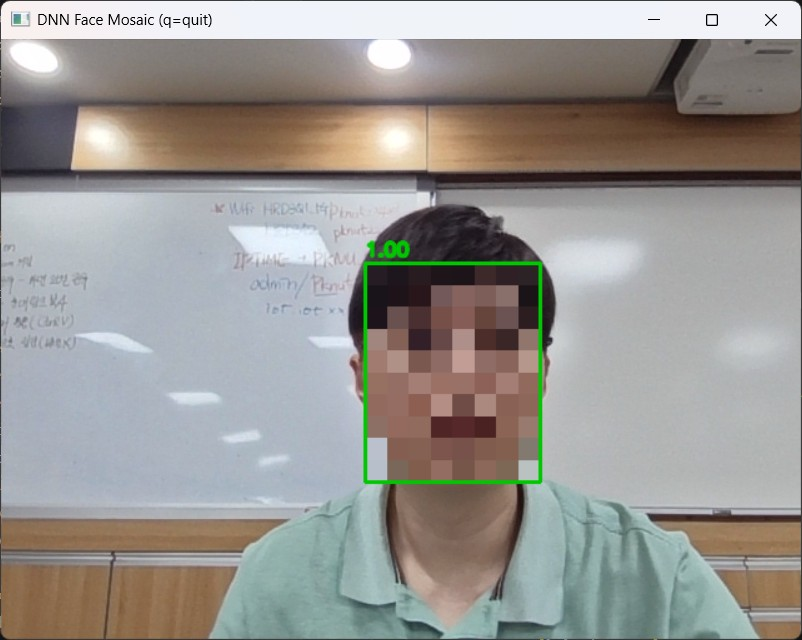